# Detección de genomas anómalos de SARS-CoV-2 por medio de algoritmos de aprendizaje no supervisados 

# Algoritmos de detección de anomalías

En este Jupyter Notebook se aplican diferentes algoritmos de detección de anomalías (*DBSCAN*, *LOF*, *detección de anomalías con k-medias* y *bosque de aislamiento*) al conjunto de usos de codones del SARS-CoV-2.

## ➤ Bibliotecas necesarias y configuración inicial

In [1]:
from IPython.display import display
from ipywidgets import widgets, interact
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import euclidean, cityblock, cdist
from scipy.stats import wasserstein_distance, entropy, pearsonr, spearmanr
from scipy.stats.mstats import gmean
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans

Configuración para el estilo a utilizar en las gráficas.

In [2]:
BACK = 'white'
FRONT = (230/255,236/255,245/255)

plt.rc('figure', facecolor=BACK, edgecolor='white')
plt.rc('axes', facecolor=FRONT, edgecolor='white', labelsize=14, labelweight='medium', titlesize=18, grid=True, axisbelow=True)
plt.rc('grid', color='white')

pd.set_option('display.max_rows', 6)
pd.set_option('display.max_columns', 11)

---

## ➤ Obtención de los datos a trabajar

Se obtiene el conjunto de datos de todos los genomas secuenciados de SARS-CoV-2, previamente pre-procesados.

In [3]:
dataset = pd.read_csv('Archivos/mex_genomes.csv', parse_dates=['Date'])
# Nombres de columnas de codones
codons = [str(i) for i in range(64)]
dataset

,Date,Virus,State,Description,0,...,61,62,63,Errors,Codons
0,2020-01-01,EPI_ISL_913918,Oaxaca,OAX-InDRE_114,0.035689,...,0.013952,0.019816,0.033667,9,9891
1,2020-01-01,EPI_ISL_914878,Tamaulipas,TAM-InDRE_125,0.035963,...,0.014042,0.019699,0.033842,1,9899
2,2020-01-01,EPI_ISL_933664,Estado de Mexico,MEX-InDRE_187,0.035869,...,0.013944,0.019905,0.033849,3,9897
...,...,...,...,...,...,...,...,...,...,...,...
51319,2022-06-15,EPI_ISL_13454152,Ciudad de México,CMX_InDRE_FD13769_E_S13666,0.036473,...,0.014122,0.019811,0.034034,43,9843
51320,2022-06-16,EPI_ISL_13454153,Ciudad de México,CMX_InDRE_FD13789_E_S13667,0.036329,...,0.014066,0.019632,0.033900,1,9882
51321,2022-06-16,EPI_ISL_13454154,Ciudad de México,CMX_InDRE_FD13793_E_S13668,0.036310,...,0.013857,0.019723,0.034287,1,9887


In [4]:
# Funcion para realizar la transformación log-cociente
def clr_transform(data):
    data = data.replace(0,0.0001)
    mg = data.apply(lambda row: gmean(row), axis=1)
    return np.log(data.divide(mg, axis=0))

In [5]:
def plot_DBSCAN(data, labels):
    # Se crea figura
    fig, axes = plt.subplot_mosaic(mosaic='A;B', figsize=(15,10), tight_layout=True)
    # Se grafican los datos
    sns.scatterplot(data=dbscan_clusters, x='Date', y=labels, hue=labels, 
                    palette='tab10', alpha=0.5, s=150, linewidth=0, ax=axes['A'])
    # Se modifica la visualizacion de la grafica
    axes['A'].legend(title='Etiquetas', fontsize=12)
    unique_labels = dbscan_clusters[labels].unique()
    axes['A'].set_yticks(np.sort(unique_labels))
    axes['A'].tick_params(axis='both', labelsize=14)
    axes['A'].set_xlabel('', fontdict=dict(size=15, weight='bold'))
    axes['A'].set_ylabel('Etiquetas de DBSCAN', fontdict=dict(size=15, weight='bold'))
    # Se crea la grafica de barras
    bar = (
        dbscan_clusters
        [dbscan_clusters[labels] == -1]
        .groupby(by='State', as_index=False)
        ['Virus']
        .count()
        .sort_values(by='Virus', ascending=False)
        .reset_index(drop=True)
        .rename(columns={'Virus':'Noisy_samples'})
        .plot.bar(x='State', y='Noisy_samples', color='tab:blue', xlabel='', ylabel='', legend=False, fontsize=14, ax=axes['B'])
    )
    # Se modifica la visualizacion de la grafica
    axes['B'].bar_label(bar.containers[0], color='darkolivegreen', fontsize=14);
    axes['B'].set_ylim(0,bar.containers[0].datavalues[0] + 2);
    axes['B'].tick_params(axis='both', labelsize=14)
    axes['B'].set_xlabel('', fontdict=dict(size=15, weight='bold'))
    axes['B'].set_ylabel('Anomalías', fontdict=dict(size=15, weight='bold'))
    fig.savefig(f'Images/anomalies_DBSCAN_{labels}.pdf', dpi=1000, bbox_inches='tight', facecolor='none')
    fig.savefig(f'Images(jpg)/anomalies_DBSCAN_{labels}.jpg', dpi=1000, bbox_inches='tight', facecolor='none')

In [6]:
def plot_anomalies(data, fig_name):
    # Se crea la figura
    fig, axes = plt.subplot_mosaic(mosaic='A;A;B;B;C', figsize=(14,16), constrained_layout=True)
    # Se seleccionan las anomalias
    anomalies = data.query('Anomaly == -1')
    threshold = anomalies['Anomaly_Scores'].min()
    # Se grafica el puntaje de anomalia por fecha
    sns.scatterplot(data=data, x='Date', y='Anomaly_Scores', alpha=0.5, color='tab:blue', ax=axes['A'], linewidth=0, legend=False);
    axes['A'].tick_params(axis='both', labelsize=14)
    axes['A'].set_xlabel('', fontdict=dict(size=15, weight='bold'))
    axes['A'].set_ylabel('Puntaje de anomalía', fontdict=dict(size=15, weight='bold'))
    axes['A'].axhline(threshold, color='black', alpha=0.5, linestyle='--', label='Umbral');
    axes['A'].legend(fontsize=12);
    # Se grafica el puntaje de anomalia por estado
    sns.scatterplot(data=data.sort_values('State'), x='State', y='Anomaly_Scores', alpha=0.5, color='tab:blue', ax=axes['B'], linewidth=0, legend=False);
    axes['B'].tick_params(axis='both', labelsize=14)
    axes['B'].tick_params(axis='x', rotation=90)
    axes['B'].set_xlabel('', fontdict=dict(size=15, weight='bold'))
    axes['B'].set_ylabel('Puntaje de anomalía', fontdict=dict(size=15, weight='bold'))
    axes['B'].axhline(threshold, color='black', alpha=0.5, linestyle='--', label='Umbral');
    axes['B'].legend(fontsize=12);
    # Se muestran el numero de instancias mas anomalas por estado
    bar = (
        anomalies
        .groupby(by='State', as_index=False)
        ['Virus']
        .count()
        .sort_values(by='Virus', ascending=False)
        .reset_index(drop=True)
        .rename(columns={'Virus':'Anomalies'})
        .plot.bar(x='State', y='Anomalies', color='tab:blue', xlabel='', 
                  ylabel='', legend=False, fontsize=14, ax=axes['C'])
    )
    axes['C'].bar_label(bar.containers[0], color='darkolivegreen', fontsize=14);
    axes['C'].tick_params(axis='both', labelsize=14)
    axes['C'].set_xlabel('', fontdict=dict(size=15, weight='bold'))
    axes['C'].set_ylabel('Anomalías', fontdict=dict(size=15, weight='bold'));
    fig.savefig(f'Images/{fig_name}.pdf', dpi=1000, bbox_inches='tight', facecolor='none')
    fig.savefig(f'Images(jpg)/{fig_name}.jpg', dpi=1000, bbox_inches='tight', facecolor='none')

In [7]:
def get_anomalies_kmeans_by_groups(dataset_by_groups, group, n=10, top=50):
    kmeans_score_frames = []
    # Para todos los usos de codones de un grupo en particular
    for group_name, dataset in dataset_by_groups:
        # Se seleccionan solo el uso de codones y se transforma
        #data = clr_transform(dataset[codons])
        data = dataset[codons]
        # Se definen los clusters como el numero de instancias sobre n
        clusters = np.ceil(data.shape[0]/n).astype('int64')    
        # Se crea modelo de agrupamiento de k-medias
        clustering_model = KMeans(n_clusters=clusters, n_init=10, random_state=0).fit(data)
        # Se obtienen los centrides
        centers = clustering_model.cluster_centers_
        # Se crea tabla con la distancia a los centros generados
        kmeans_score = dataset.select_dtypes(include=['object','datetime64']).copy()
        kmeans_score[group] = group_name
        # Se obtiene la distancia esperada entre cada uso de codones y los centroides
        anomaly_score = cdist(data,centers).mean(axis=1).reshape(-1,1)
        #anomaly_score = anomaly_score - anomaly_score.min()
        kmeans_score['Anomaly_Score'] = anomaly_score
        kmeans_score_frames.append(kmeans_score)

    dataset_kmeans_score_by_groups = pd.concat(kmeans_score_frames, ignore_index=True)
    # Los usos de codones que en promedio mas se alejen de sus centroides se consideran anomalias
    threshold = dataset_kmeans_score_by_groups.nlargest(top, 'Anomaly_Score')['Anomaly_Score'].min()
    anomalies = (dataset_kmeans_score_by_groups['Anomaly_Score'] >= threshold).astype('int64')
    dataset_kmeans_score_by_groups['Anomaly'] = np.where(anomalies == 1, -1, 1)
    
    return dataset_kmeans_score_by_groups

## ➤ DBSCAN

El algoritmo \textit{DBSCAN} se aplicó con un radio de vecindad \textit{eps} igual a 0.005. Este valor se eligió después de analizar la distribución de las distancias esperadas del conjunto de genomas. En dicha distribución, se encontró que aproximadamente el 1.84\% de las instancias se encuentran a una distancia esperada mayor a 0.005.

El script ```DBSCAN.py``` calcula la etiqueta de cada instancia, en este caso se utilizaron dos modelos con el parámetro ```eps=0.008``` y ```eps=0.005```. Obteniendo así dos etiquetados (```Label1``` y ```Label2```, respectivamente) para todas las instancias.

In [8]:
# Se obtienen las etiquetas generadas por DBSCAN en el archivo DBSCAN.py
dbscan_clusters = pd.read_csv('Archivos/DBSCAN_labels.csv', parse_dates=['Date'])
dbscan_clusters

,Date,Virus,State,Description,Label1,Label2,Errors,Codons
0,2020-01-01,EPI_ISL_913918,Oaxaca,OAX-InDRE_114,0,0,9,9891
1,2020-01-01,EPI_ISL_914878,Tamaulipas,TAM-InDRE_125,0,0,1,9899
2,2020-01-01,EPI_ISL_933664,Estado de Mexico,MEX-InDRE_187,0,0,3,9897
...,...,...,...,...,...,...,...,...
51319,2022-06-15,EPI_ISL_13454152,Ciudad de México,CMX_InDRE_FD13769_E_S13666,0,0,43,9843
51320,2022-06-16,EPI_ISL_13454153,Ciudad de México,CMX_InDRE_FD13789_E_S13667,0,0,1,9882
51321,2022-06-16,EPI_ISL_13454154,Ciudad de México,CMX_InDRE_FD13793_E_S13668,0,0,1,9887


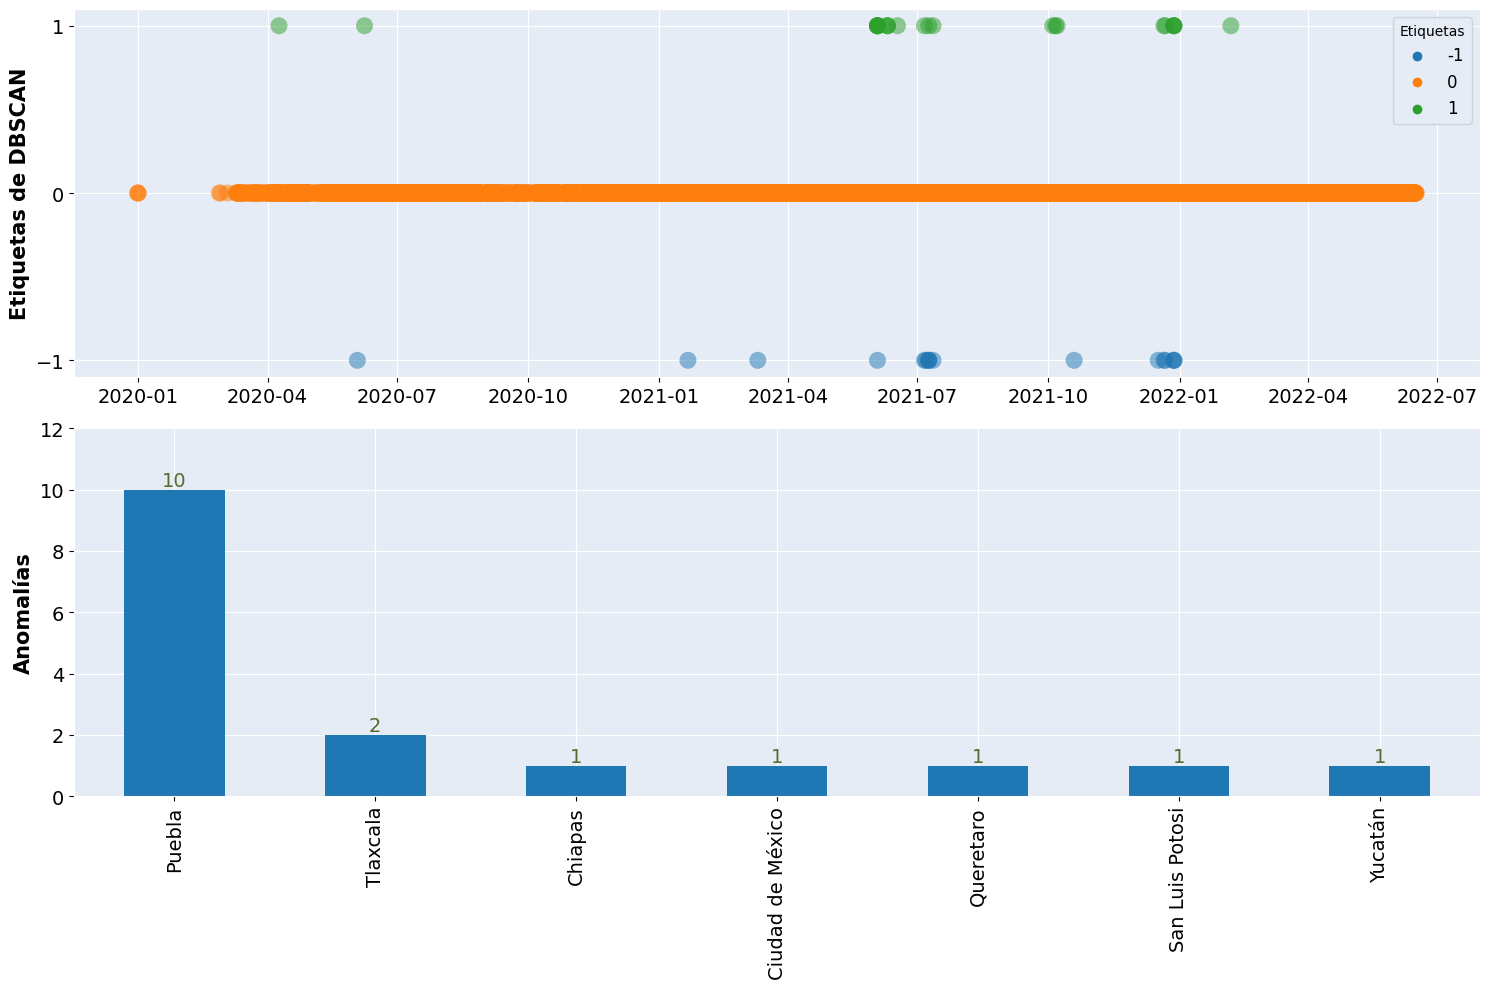

In [9]:
plot_DBSCAN(dbscan_clusters, 'Label1')

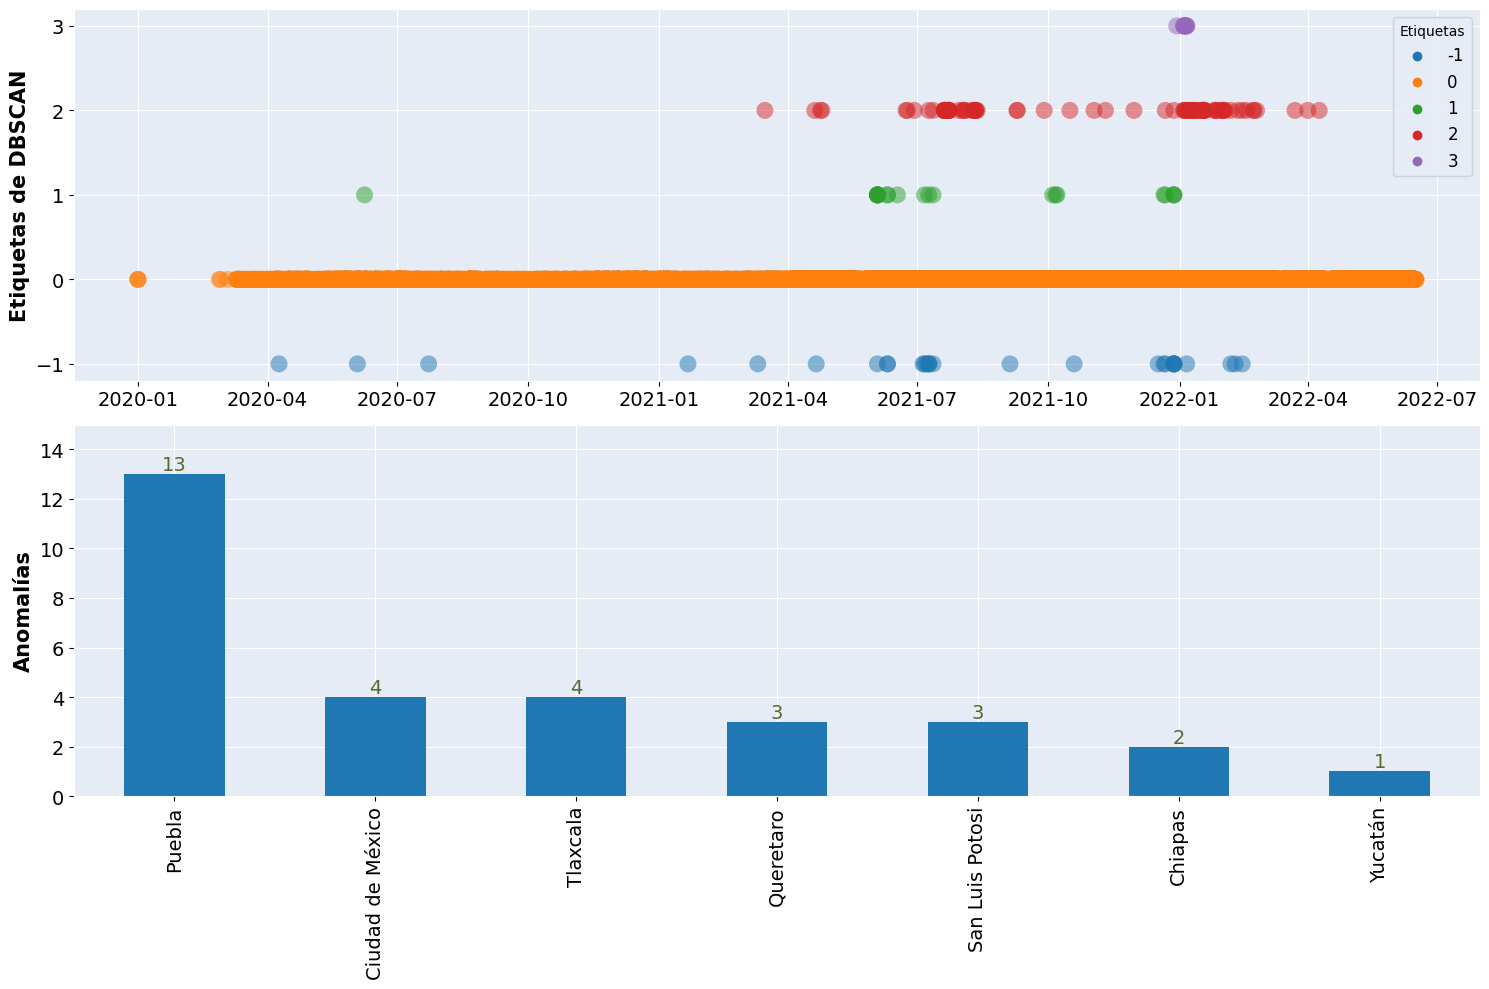

In [10]:
plot_DBSCAN(dbscan_clusters, 'Label2')

## ➤ K-Medias

En este caso, el algoritmo de *k-medias* se aplicó a subconjuntos de los datos en lugar de al conjunto de datos completo. Se utilizaron dos criterios diferentes para la selección de estos subconjuntos. El primer criterio se basó en los estados de registro, mientras que el segundo se centró en la selección de periodos de tiempo con la misma cantidad de genomas registrados.

In [11]:
stats = pd.read_csv('Archivos/codon_usage_stats.csv', parse_dates=['Date'])
stats

,Date,Virus,State,Description,Human_Euclidean,Human_Wasserstein,Entropy,Mean_Logratio_dist,Errors,Codons
0,2020-01-01,EPI_ISL_913918,Oaxaca,OAX-InDRE_114,0.095266,2.415117,5.658083,0.204594,9,9891
1,2020-01-01,EPI_ISL_914878,Tamaulipas,TAM-InDRE_125,0.095288,2.422777,5.657209,0.196124,1,9899
2,2020-01-01,EPI_ISL_933664,Estado de Mexico,MEX-InDRE_187,0.095266,2.427153,5.657930,0.200951,3,9897
...,...,...,...,...,...,...,...,...,...,...
51319,2022-06-15,EPI_ISL_13454152,Ciudad de México,CMX_InDRE_FD13769_E_S13666,0.095346,2.442552,5.657989,0.233457,43,9843
51320,2022-06-16,EPI_ISL_13454153,Ciudad de México,CMX_InDRE_FD13789_E_S13667,0.095309,2.424662,5.657191,0.241662,1,9882
51321,2022-06-16,EPI_ISL_13454154,Ciudad de México,CMX_InDRE_FD13793_E_S13668,0.095365,2.432371,5.657354,0.233939,1,9887


### • Anomalías por estados

Este procedimiento consistió en dividir el conjunto de datos en 32 subconjuntos distintos, correspondientes a los estados de la república. La selección de los centroides para cada subconjunto se determinó dividiendo el número total de instancias de cada uno de estos sobre 20.

In [12]:
top = 50
n = 20

# Se obtienen los estados unicos
states = dataset['State'].unique()
states = np.sort(states)
dataset_by_states = [(state, dataset.query('State == @state')) for state in states]

# Se obtiene el puntaje de anomalia por medio de K-medias
kmeans_score_by_states = get_anomalies_kmeans_by_groups(dataset_by_states, 'State', n=n, top=top)
kmeans_score_by_states.to_csv('Archivos/kmeans_states_labels.csv', index=False)
kmeans_score_by_states

,Date,Virus,State,Description,Anomaly_Score,Anomaly
0,2020-04-09,EPI_ISL_3463645,Aguascalientes,AGU-InDRE-IBT-2320,0.004129,1
1,2020-06-15,EPI_ISL_576258,Aguascalientes,AGU-InDRE-55,0.003000,1
2,2020-08-07,EPI_ISL_576261,Aguascalientes,AGU-InDRE-58,0.002942,1
...,...,...,...,...,...,...
51319,2022-05-30,EPI_ISL_13404941,Zacatecas,ZAC_IBT_IMSS_7389,0.002889,1
51320,2022-05-31,EPI_ISL_13404940,Zacatecas,ZAC_IBT_IMSS_7388,0.002920,1
51321,2022-06-03,EPI_ISL_13404939,Zacatecas,ZAC_IBT_IMSS_7391,0.002906,1


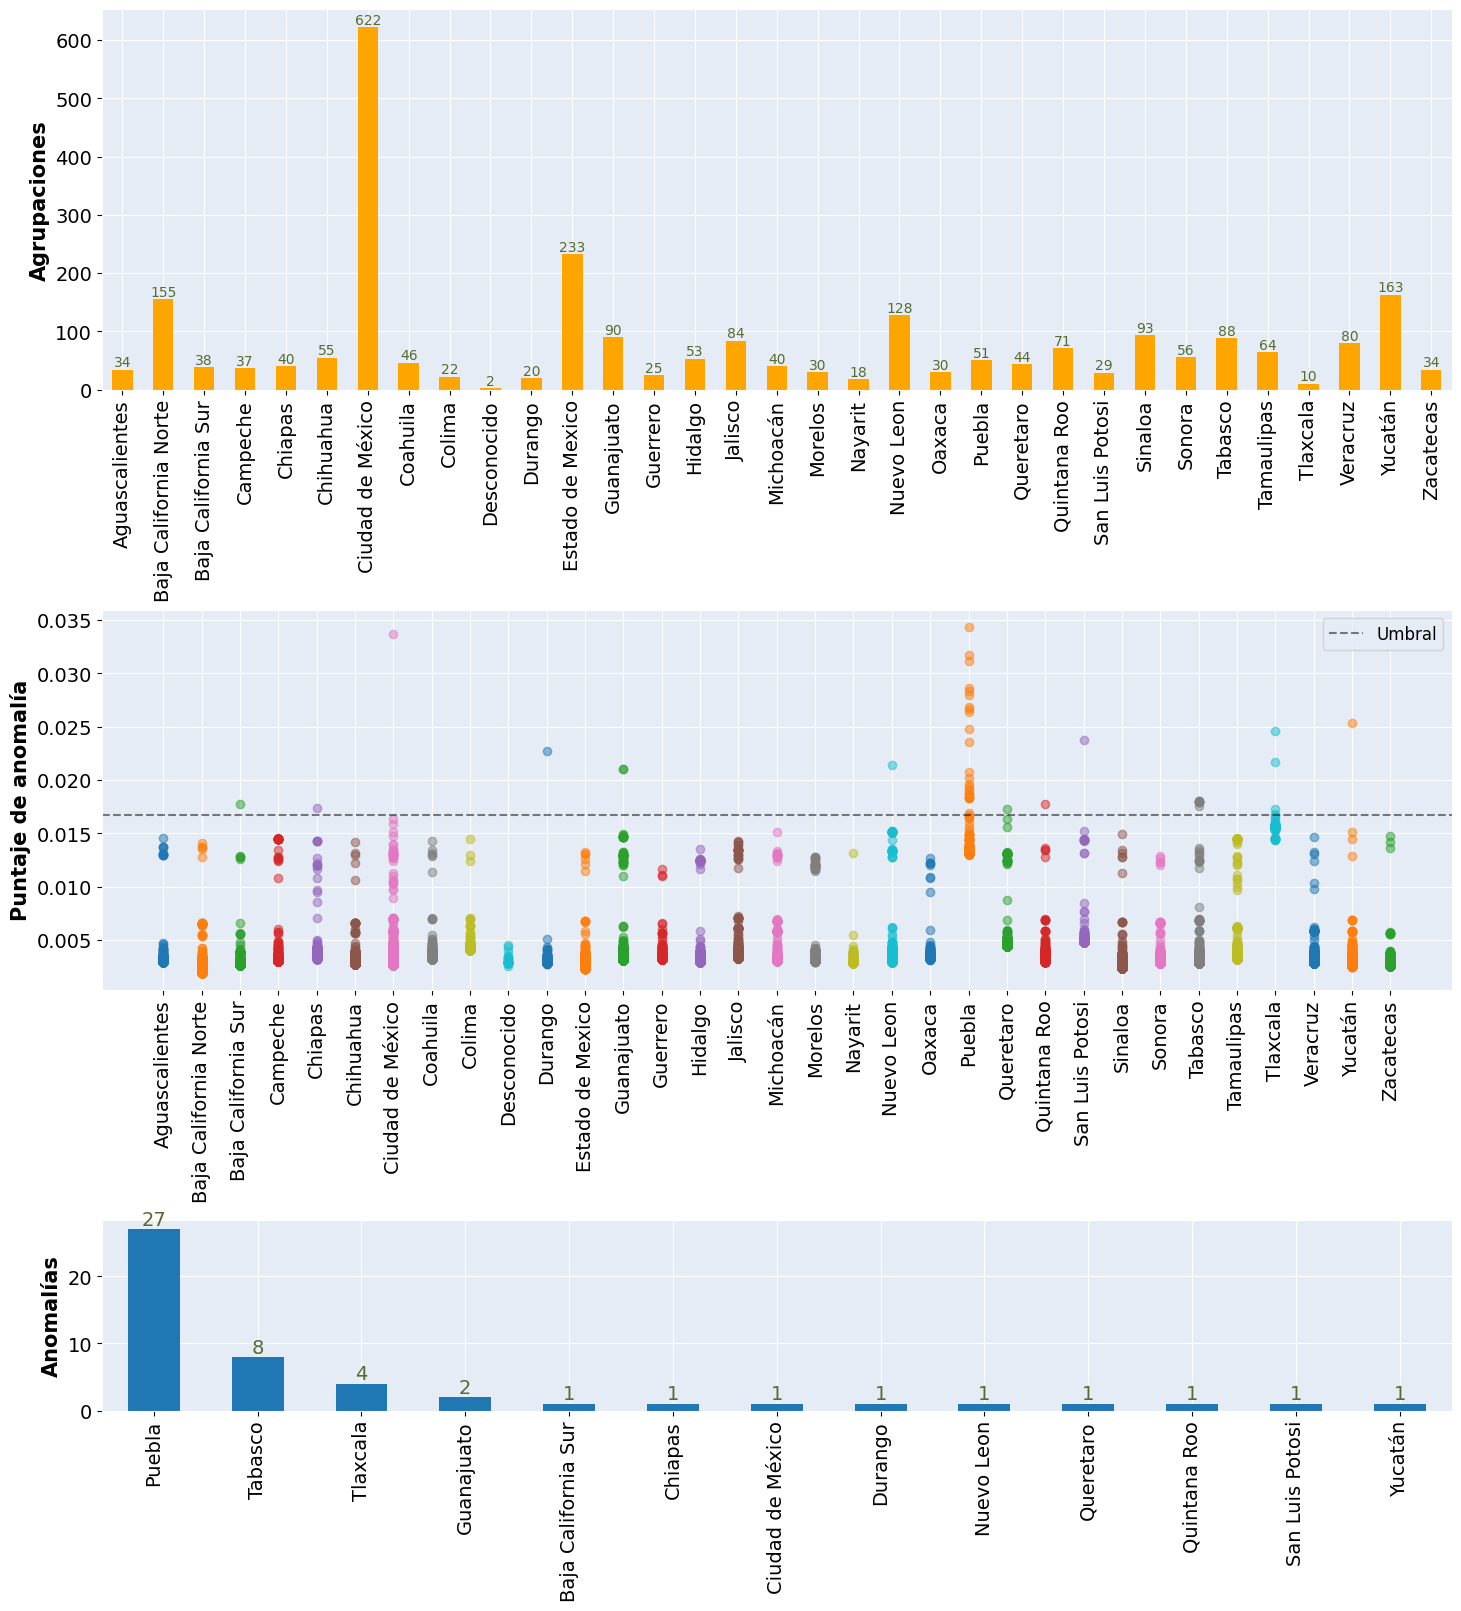

In [13]:
fig, axes = plt.subplot_mosaic(mosaic="A;A;B;B;C",figsize=(14.5,16), constrained_layout=True)
colors = sns.color_palette('tab10', len(states)).as_hex()

bar = (
    dataset
    [['State','Virus']]
    .groupby('State')
    .count()
    .divide(n)
    .apply(lambda x: np.ceil(x))
    .astype('int64')
    .plot.bar(color='orange', xlabel='',
              legend=False, ax=axes['A'])
)
axes['A'].bar_label(bar.containers[0], color='darkolivegreen');
axes['A'].set_ylabel('Agrupaciones', fontdict=dict(size=15, weight='bold'))
axes['A'].tick_params(axis='x', labelsize=13)
axes['A'].tick_params(axis='both', labelsize=14)

for state, color in zip(states,colors):
    scores = kmeans_score_by_states.query('State == @state')
    axes['B'].scatter(scores['State'], scores['Anomaly_Score'], alpha=0.5, color=color, zorder=1)

# Se obtiene el umbral de anomalia
threshold = kmeans_score_by_states.query('Anomaly == -1')['Anomaly_Score'].min()

axes['B'].tick_params(axis='both', labelsize=14)
axes['B'].tick_params(axis='x', rotation=90)
axes['B'].set_xlabel('', fontdict=dict(size=15, weight='bold'))
axes['B'].set_ylabel('Puntaje de anomalía', fontdict=dict(size=15, weight='bold'))
axes['B'].axhline(threshold, color='black', alpha=0.5, linestyle='--', label='Umbral');
axes['B'].legend(fontsize=12);

bar = (
    kmeans_score_by_states
    .query('Anomaly == -1')
    .groupby(by='State', as_index=False)
    ['Virus']
    .count()
    .sort_values(by='Virus', ascending=False)
    .reset_index(drop=True)
    .rename(columns={'Virus':'Anomalies'})
    .plot.bar(x='State', y='Anomalies', color='tab:blue', xlabel='', 
              ylabel='', legend=False, fontsize=14, ax=axes['C'])
)

axes['C'].bar_label(bar.containers[0], color='darkolivegreen', fontsize=14);
axes['C'].tick_params(axis='both', labelsize=14)
axes['C'].set_xlabel('', fontdict=dict(size=15, weight='bold'))
axes['C'].set_ylabel('Anomalías', fontdict=dict(size=15, weight='bold'));

fig.savefig(f'Images/anomalies_kmeans_by_state.pdf', dpi=1000, bbox_inches='tight', facecolor='none')
fig.savefig(f'Images(jpg)/anomalies_kmeans_by_state.jpg', dpi=1000, bbox_inches='tight', facecolor='none')

### • Anomalías por periodos de tiempo

El segundo criterio consistió en dividir el conjunto de datos en 10 períodos de tiempo diferentes, cada uno con la misma cantidad de instancias (5,132 genomas). Luego, se eligieron los centroides para cada periodo dividiendo su número total de instancias sobre 20.

In [14]:
top = 50
n = 20
periods = 10

dataset_by_periods = [(period, data) for period, data in enumerate(np.array_split(dataset, periods), start=1)]
# Se obtiene el puntaje de anomalia por medio de K-medias
kmeans_score_by_periods = get_anomalies_kmeans_by_groups(dataset_by_periods, 'Period', n=n, top=top)
kmeans_score_by_periods.to_csv('Archivos/kmeans_periods_labels.csv', index=False)
kmeans_score_by_periods

,Date,Virus,State,Description,Period,Anomaly_Score,Anomaly
0,2020-01-01,EPI_ISL_913918,Oaxaca,OAX-InDRE_114,1,0.003175,1
1,2020-01-01,EPI_ISL_914878,Tamaulipas,TAM-InDRE_125,1,0.003163,1
2,2020-01-01,EPI_ISL_933664,Estado de Mexico,MEX-InDRE_187,1,0.003142,1
...,...,...,...,...,...,...,...
51319,2022-06-15,EPI_ISL_13454152,Ciudad de México,CMX_InDRE_FD13769_E_S13666,10,0.002841,1
51320,2022-06-16,EPI_ISL_13454153,Ciudad de México,CMX_InDRE_FD13789_E_S13667,10,0.002731,1
51321,2022-06-16,EPI_ISL_13454154,Ciudad de México,CMX_InDRE_FD13793_E_S13668,10,0.002783,1


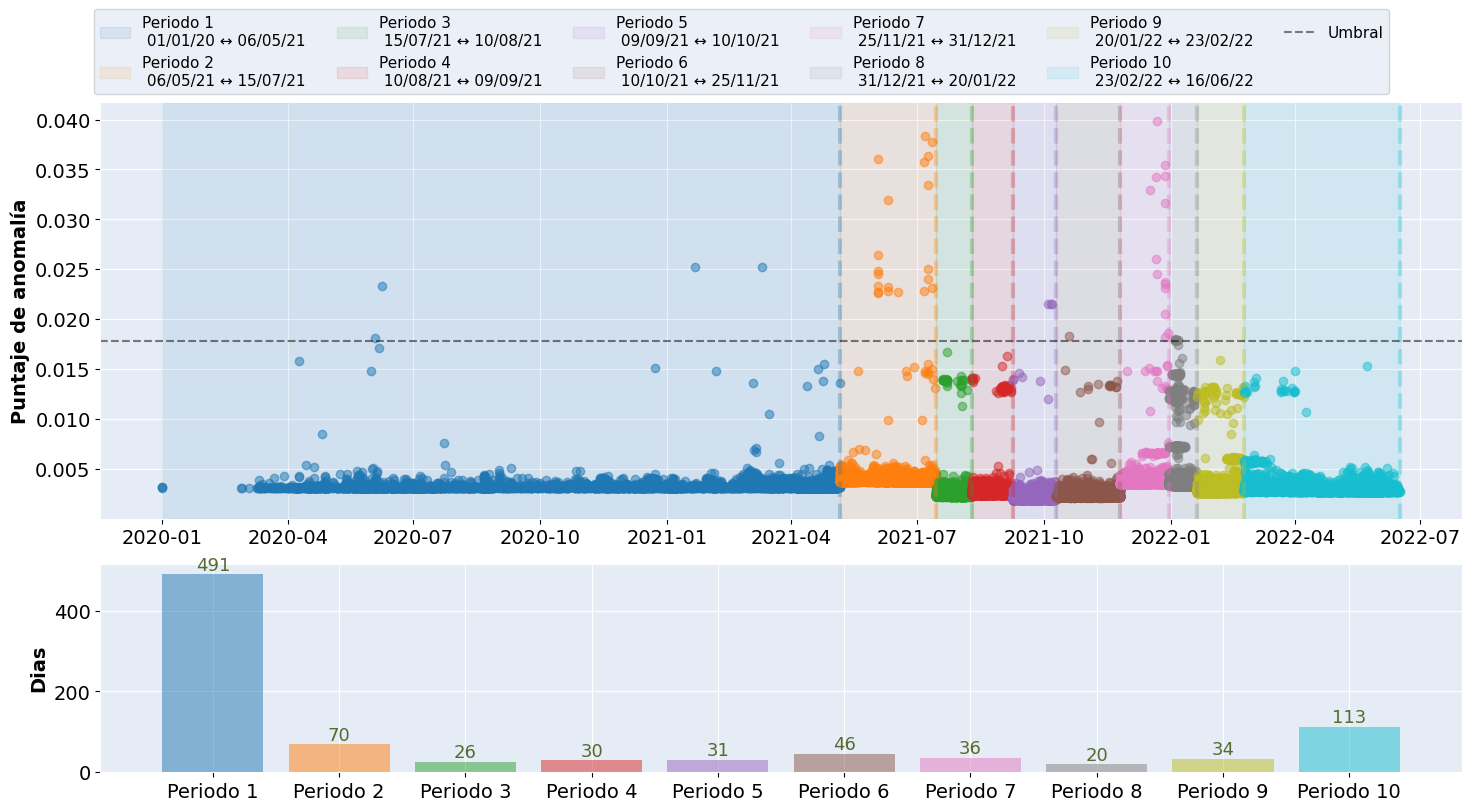

In [15]:
fig, axes = plt.subplot_mosaic(mosaic="A;A;B",figsize=(14.6,8), constrained_layout=True)
colors = sns.color_palette('tab10', periods).as_hex()

for period, color in enumerate(colors, start=1):
    scores = kmeans_score_by_periods.query('Period == @period')
    # Se visualiza el inicio y fin del periodo
    start = scores['Date'].iloc[0]
    end = scores['Date'].iloc[-1]
    axes['A'].axvspan(start, end, alpha=0.1, color=color, label=f"Periodo {period} \n {start.strftime('%d/%m/%y')} ↔ {end.strftime('%d/%m/%y')}")
    axes['A'].axvline(end, linestyle='--', linewidth=3, alpha=0.3, color=color)
    # Se grafica la el puntaje de anomalia
    axes['A'].scatter(scores['Date'], scores['Anomaly_Score'], alpha=0.5, color=color, zorder=1)
    bar = axes['B'].bar(f'Periodo {period}', (end-start).days, color=color, alpha=0.5)
    axes['B'].bar_label(bar, fontsize=13, color='darkolivegreen')

# Se obtiene el umbral de anomalia
threshold = kmeans_score_by_periods.query('Anomaly == -1')['Anomaly_Score'].min()

axes['A'].axhline(threshold, color='black', alpha=0.5, linestyle='--', label='Umbral');
axes['A'].set_ylabel('Puntaje de anomalía', fontdict=dict(size=14, weight='bold'))
axes['A'].tick_params(axis='x', labelsize=13)
axes['A'].tick_params(axis='both', labelsize=14)
axes['A'].legend(fontsize=11, bbox_to_anchor=(-0.005,1.02), title='', loc="lower left",
                 title_fontproperties=dict(weight='bold', size=14), borderaxespad=0., ncols=6);

axes['B'].set_ylabel('Dias', fontdict=dict(size=14, weight='bold'));
axes['B'].tick_params(axis='x', labelsize=13)
axes['B'].tick_params(axis='both', labelsize=14)
fig.savefig(f'Images/anomalies_kmeans_by_period_1.pdf', dpi=1000, bbox_inches='tight', facecolor='none')
fig.savefig(f'Images(jpg)/anomalies_kmeans_by_period_1.jpg', dpi=1000, bbox_inches='tight', facecolor='none')

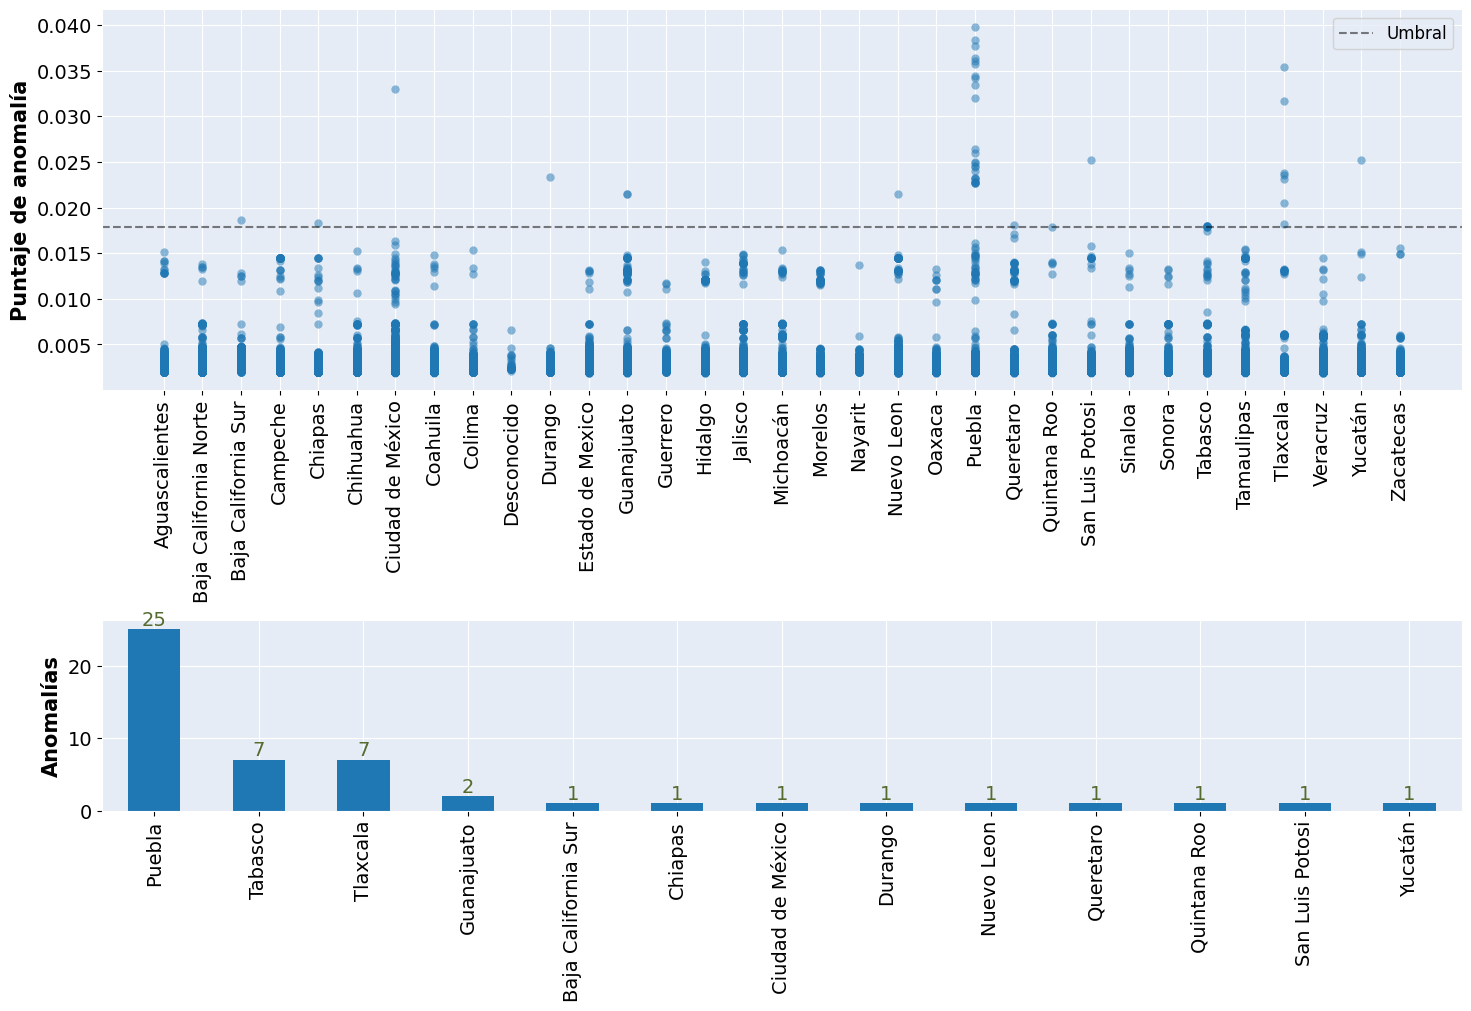

In [16]:
fig, axes = plt.subplot_mosaic(mosaic="A;A;B",figsize=(14.6,10), constrained_layout=True)

# Se grafica el puntaje de anomalia calculado dentro de cada periodo
sns.scatterplot(data=kmeans_score_by_periods.sort_values('State'), x='State', y='Anomaly_Score', color='tab:blue', ax=axes['A'], linewidth=0, alpha=0.5)

axes['A'].tick_params(axis='both', labelsize=14)
axes['A'].tick_params(axis='x', rotation=90)
axes['A'].set_xlabel('', fontdict=dict(size=15, weight='bold'))
axes['A'].set_ylabel('Puntaje de anomalía', fontdict=dict(size=15, weight='bold'))
axes['A'].axhline(threshold, color='black', alpha=0.5, linestyle='--', label='Umbral');
axes['A'].legend(fontsize=12);

bar = (
    kmeans_score_by_periods
    .query('Anomaly == -1')
    .groupby(by='State', as_index=False)
    ['Virus']
    .count()
    .sort_values(by='Virus', ascending=False)
    .reset_index(drop=True)
    .rename(columns={'Virus':'Anomalies'})
    .plot.bar(x='State', y='Anomalies', color='tab:blue', xlabel='', 
              ylabel='', legend=False, fontsize=14, ax=axes['B'])
)

axes['B'].bar_label(bar.containers[0], color='darkolivegreen', fontsize=14);
axes['B'].tick_params(axis='both', labelsize=14)
axes['B'].set_xlabel('', fontdict=dict(size=15, weight='bold'))
axes['B'].set_ylabel('Anomalías', fontdict=dict(size=15, weight='bold'));
fig.savefig(f'Images/anomalies_kmeans_by_period_2.pdf', dpi=1000, bbox_inches='tight', facecolor='none')
fig.savefig(f'Images(jpg)/anomalies_kmeans_by_period_2.jpg', dpi=1000, bbox_inches='tight', facecolor='none')

## ➤ Local Outlier Factor

El algoritmo *LOF* se computó utilizando un valor de vecinos *k* igual a 50.

In [17]:
data = dataset[codons]
# Se crea el modelo de LOF
lof_model = LocalOutlierFactor(n_neighbors=50, contamination=0.001)
# Se crea un dataframe con los puntajes de anomalia calculados por el modelo
data_lof_score = dataset.select_dtypes(include=['object','datetime64']).copy()
data_lof_score['Anomaly'] = lof_model.fit_predict(data)
data_lof_score['Anomaly_Scores'] = -lof_model.negative_outlier_factor_
data_lof_score.to_csv('Archivos/LOF_labels.csv', index=False)
data_lof_score

,Date,Virus,State,Description,Anomaly,Anomaly_Scores
0,2020-01-01,EPI_ISL_913918,Oaxaca,OAX-InDRE_114,1,1.802529
1,2020-01-01,EPI_ISL_914878,Tamaulipas,TAM-InDRE_125,1,1.529184
2,2020-01-01,EPI_ISL_933664,Estado de Mexico,MEX-InDRE_187,1,1.591071
...,...,...,...,...,...,...
51319,2022-06-15,EPI_ISL_13454152,Ciudad de México,CMX_InDRE_FD13769_E_S13666,1,2.245161
51320,2022-06-16,EPI_ISL_13454153,Ciudad de México,CMX_InDRE_FD13789_E_S13667,1,1.428287
51321,2022-06-16,EPI_ISL_13454154,Ciudad de México,CMX_InDRE_FD13793_E_S13668,1,0.993066


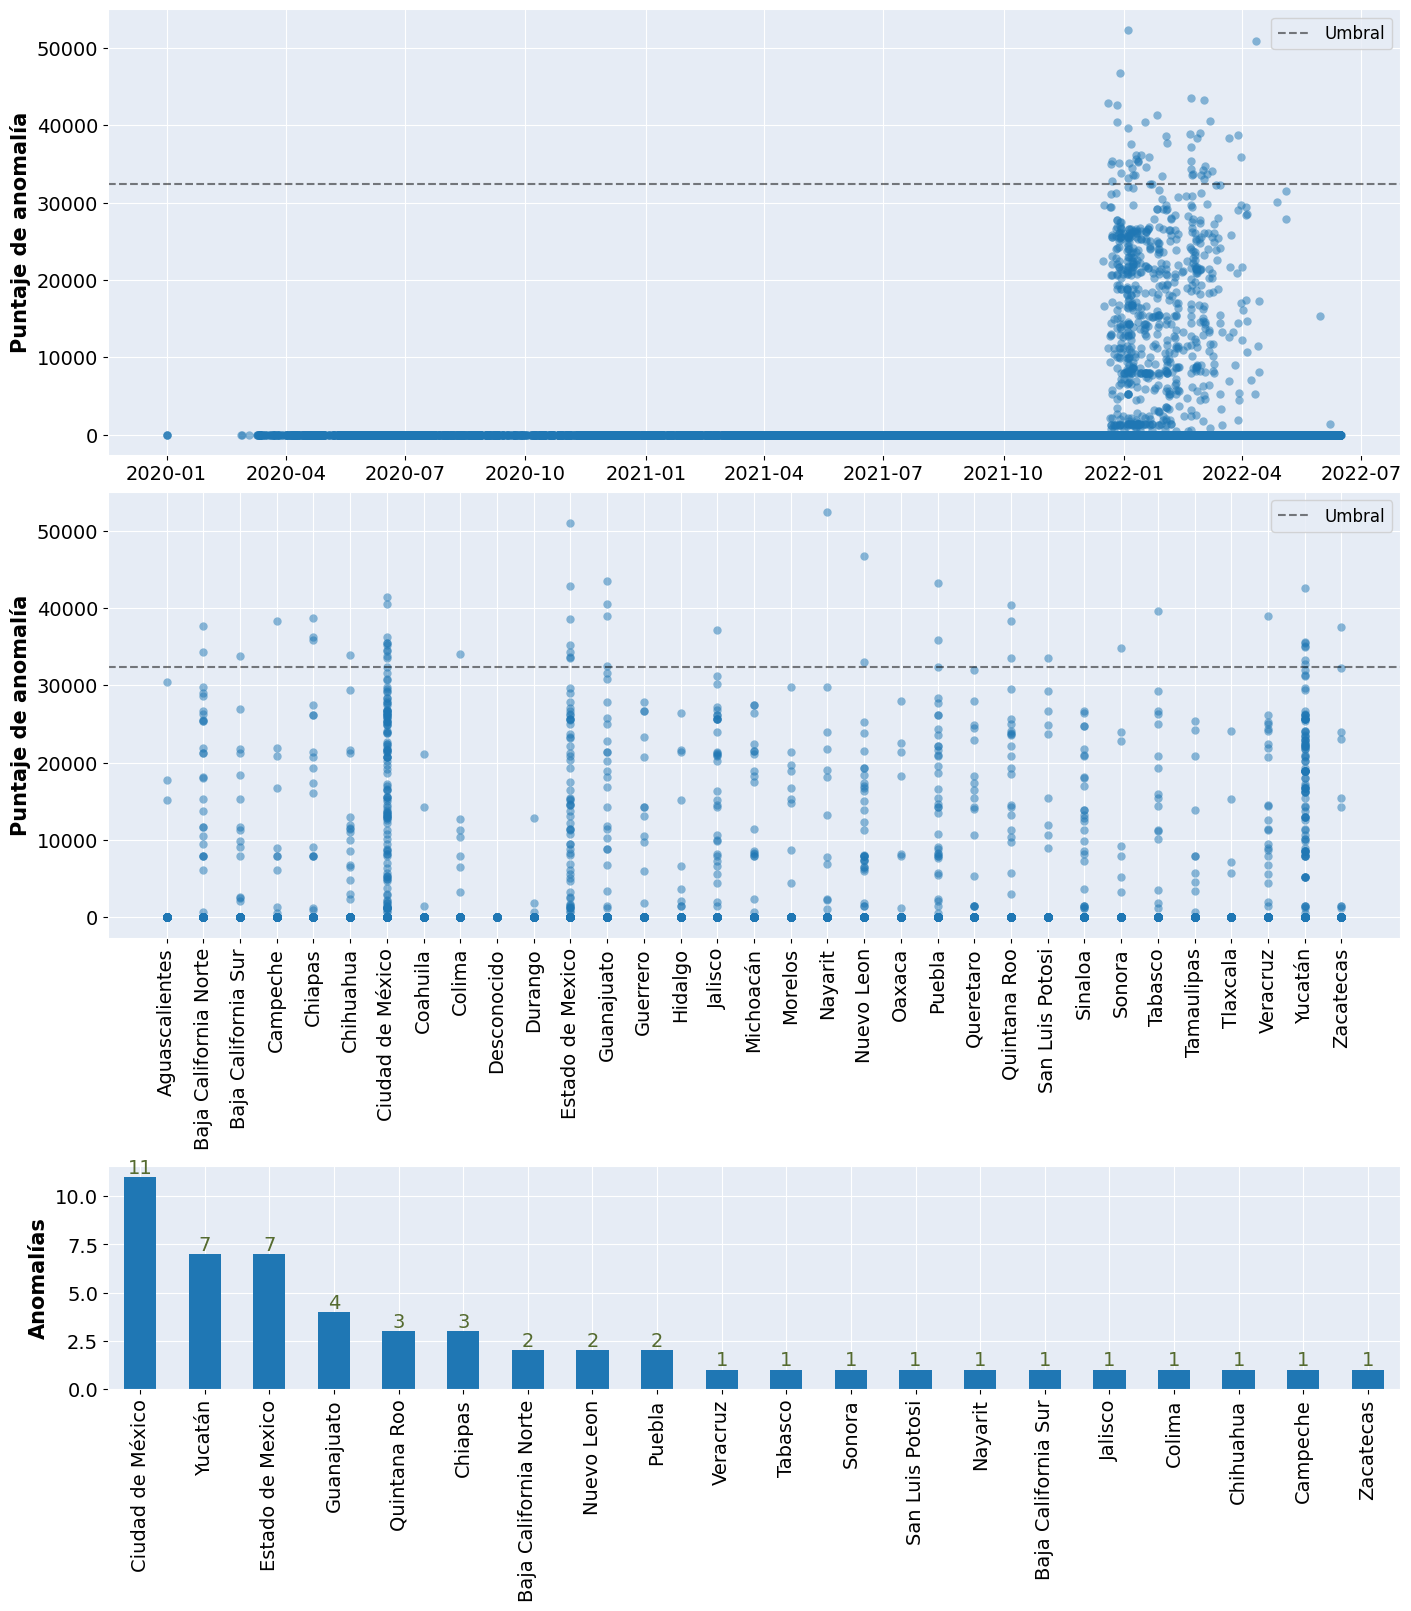

In [18]:
plot_anomalies(data_lof_score, fig_name='anomalies_LocalOutlierFactor')

## ➤ Bosque de aislamiento

En este caso, se utilizaron 100 \textit{árboles de aislamiento} para computar el algoritmo. Cada árbol se construyó seleccionando aleatoriamente solo el 25\% del total de instancias.

In [19]:
data = dataset[codons]
# Se crea el modelo de Bosques de aislamiento para encontrar las anomalías
model_if = IsolationForest(max_samples=0.25, contamination=0.001, random_state=0)
# Create the DataFrame to store the IF anomaly scores
data_if_score = dataset.select_dtypes(include=['object','datetime64']).copy()
data_if_score['Anomaly'] = model_if.fit_predict(data.to_numpy())
data_if_score['Anomaly_Scores'] = -model_if.score_samples(data.to_numpy())
# Se guardan los resultados
data_if_score.to_csv('Archivos/IF_labels.csv', index=False)
data_if_score

,Date,Virus,State,Description,Anomaly,Anomaly_Scores
0,2020-01-01,EPI_ISL_913918,Oaxaca,OAX-InDRE_114,1,0.336051
1,2020-01-01,EPI_ISL_914878,Tamaulipas,TAM-InDRE_125,1,0.332401
2,2020-01-01,EPI_ISL_933664,Estado de Mexico,MEX-InDRE_187,1,0.320901
...,...,...,...,...,...,...
51319,2022-06-15,EPI_ISL_13454152,Ciudad de México,CMX_InDRE_FD13769_E_S13666,1,0.353331
51320,2022-06-16,EPI_ISL_13454153,Ciudad de México,CMX_InDRE_FD13789_E_S13667,1,0.334986
51321,2022-06-16,EPI_ISL_13454154,Ciudad de México,CMX_InDRE_FD13793_E_S13668,1,0.332747


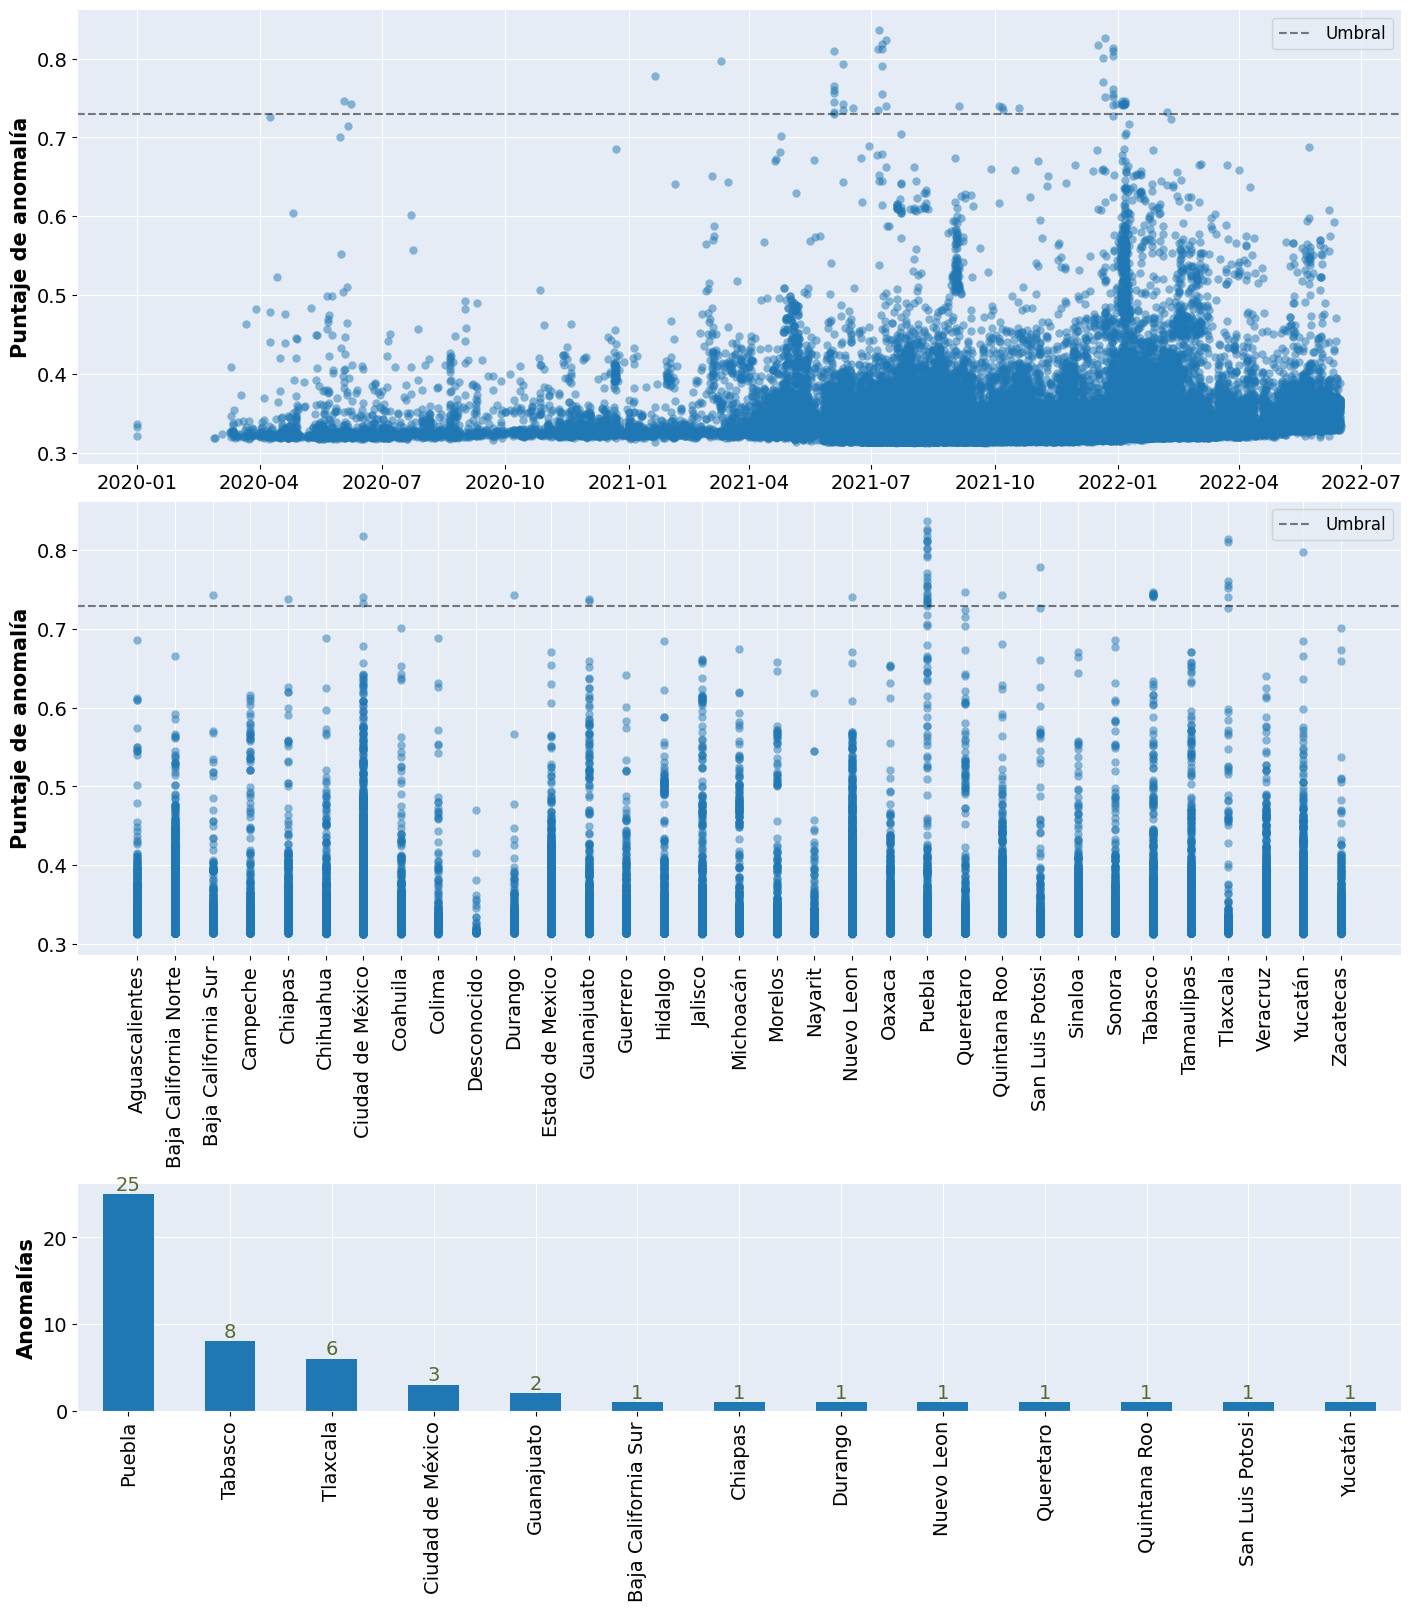

In [20]:
plot_anomalies(data_if_score, fig_name='anomalies_IsolationForest')